![LOGO_UFPR](https://seeklogo.com/images/U/UFPR-logo-F52F55C42F-seeklogo.com.png)

<h1 style="text-align: center;"> Universidade Federal do Paraná - UFPR </h1>
<br /><hr /><br />

<h2 style="text-align: center;"> SEPT - Setor de Educação Profissional e Tecnológica </h2>
<h3 style="text-align: center;"> Especialização em Inteligência Artificial Aplicada </h3>

<br />

<p style="text-align: right;"> Disciplina: Visão Computacional </p>
<p style="text-align: right;"> Turma: 2021 </p>
<p style="text-align: right;"> Aluno: Bruno Luvizotto Carli </p>
<p style="text-align: right;"> Professor: Dr. Lucas Ferrari de Oliveira </p>

<br />
<p style="text-align: center;"> Curitiba, 2022 </p> 


## Introdução

A partir de uma base de dados de imagens médicas que apresentam possibilidades patológicas de melanoma pretende-se elaborar e implementar um fluxo de processamento e classificação de novas imagens em duas categorias de previsão: melanoma e controle. A base a ser utilizada contém 68 amostras no total, sendo 23 amostras positivas (melanoma) e 45 negativas (controle). O objetivo global pode ser definido como implementar um modelo de classificação de imagens de suspeita de melânoma cujo interprete uma entrada (imagem digital) e determine se é um caso de melanoma ou um caso de controle. Como objetivos especificos pode-se elencar:

- Elaborar um pipeline de processamento e transformação dos dados;
- Treinar e validar modelos de machine learning sobre os dados;
- Otimizar os modelos e selecionar o modelo de maior acurácia;
- Avaliar e exibir as métricas do modelo:
    + Sensibilidade;
    + Especificidade;
    + Acurácia;
    + Precisão;
    + F1 *score*;

## Metodologia

A metodologia seguirá um procedimento padrão de fluxo de trabalho em *machine learning* proposto por Harrison (2020) cujo menciona ser uma expansão a metodologia CRISP-DM (*Cross-Industry Standard Process for Data Mining*):

<img src="https://www.oreilly.com/library/view/machine-learning-pocket/9781492047537/assets/mlpr_0201.png" align="center" width="400" alt="MLProcess_Harrison(2020)">

<center>
    <small>
        <i>Figura 1: Processo do Machine Learning. Fonte: Harrison (2020).</i>
    </small>
</center>

Baseado neste fluxo define-se inicialmente uma pergunta: Seria possivel, a partir do tamanho da amostra recebida, obter um modelo **Bom** ou **Excelente** conforme o *CAP* (*Cumulative Accuracy Profile*) explicado por Vallantin (2018) onde projeta-se um estimador básico chamado de *baseline* (cujo retorna o mesmo valor para todos os caso) e um estimador perfeito (a própria resposta por exemplo), a baseline é o ponto de partida de comparaçãp par aos modelos finais.

Dado que a base de dados é demasiado pequena, inviabilizando o uso de redes profundas de aprendizado, pretende-se utilizar modelos de base como Florestas Aleatórias, Gradientes Descendentes Estocásticos (SGD), Máquinas de Vetor de Suporte e Perceptron Multicamadas. O scikit-learn disponibiliza estes modelos com facil implementação, além de disponibilizar métricas de validação já implementadas.

Portanto a partir deste fluxo definiu-se alguns passos a serem tomados e realizados no fluxo:

- **Carregar e preparar os dados**:
    + Definição do local da base;
    + Carregar dados na memória;
    + Aplicar conversão de cores e redimensionamento;
- **Pré-processar os dados:**
    + Visualização dos dados;
    + Estratificação da amostra;
- **Processamento dos dados:**
    + Remoção dos canais de cor (escala de cinza);
    + Extração de propriedades com HOG;
    + Escalonamento dos dados;
- **Criação de modelos:**
    + Treinar um modelo de base;
    + Avaliar os resultados parciais;
- **Otimização:**
    + Definição de um pipeline de execução;
    + Busca de parâmetros;
    + Seleção  modelos sobre diferentes estratificações;
- **Avaliação:**
    + Comparação dos resultados;
    + Visualização dos resultados;
    + Seleção da melhor configuração obtida;
- **Armazenar o modelo final;**
- **Implantação do modelo.**

A imagem abaixo ilustra a sequência do fluxo de atividades e forma resumida, a serem executados no desenvolvimento do presente trabalho:

<img src="https://i.ibb.co/g9w4nH9/workflowv2.png" align="center" width="650" alt="Workflow">

<center>
    <small>
        <i>Figura 2: Sequência de atividades. Fonte: O autor.</i>
    </small>
</center>


### Dependências

A execução do código disponibilizado no trabalho depende da instalação via *pip* (gerenciador de pacotes do Python) as seguintes bibliotecas externas:

```
scikit-learn==0.24.1
scikit-image==0.19.1
numpy==1.18.5
matplotlib==3.3.3
pandas==1.2.1
joblib==1.1.0
seaborn==0.11.1
```

Por convenção, todo código e comentários de código serão escritos em inglês.

## Módulos necessários

Os módulos abaixo serão utilizados para o auxílio no processamento e execução das atividades:

In [1]:
%%capture
%matplotlib inline
# std sys libs
import os
from collections import Counter

# scientific computing, plotting and visualisation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# image loading, processing
import skimage
from skimage.io import imread
from skimage.transform import resize, rescale
from skimage.feature import hog
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
import joblib
import seaborn as sns

# machine learning stuff
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import (confusion_matrix, classification_report,
                             f1_score, precision_score, plot_confusion_matrix)
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

plt.style.use('seaborn')

## Carrega e prepara os dados

Inicialmente deve-se definir o caminho para o diretório onde encontram-se as amostras, este é inicialmente definido na variável `PATH`, devendo ser modificado dependendo da localização dos arquivos na máquina que executar o código. Uma semente para o motor de números pseudoaleatórios do **numpy** é configurada para garantir a reprodotibilidade dos valores obtidos.

In [2]:
PATH = 'Base'
np.random.seed(2154)  # reproducibility ON

Define-se uma função que faz o carregamento e preparação inicial dos dados. A preparação consiste na conversão da escala de cor cuja é naturalmente carregada como BGR para o formato RGB, e em seguida aplica um redimensionamento da imagem.

A base está formnada com a seguinte estrutura:


```
base
├── Negativos
│   ├── 0005_0.JPG
│   ├── 0006_0.JPG
│   ├── 0007_0.JPG
│   ├── ...
│   ├── 0511_0.jpg
│   └── 0535_0.jpg
└── Positivos
    ├── 0001_1.JPG
    ├── 0002_1.jpg
    ├── 0003_1.JPG
    ├── ...
    ├── 0028_1.jpg
    └── 0029_1.JPG

2 directories, 68 files
```

In [3]:
def load_and_resize(path, width=150, height=None):
    # if no height was given, use same as width
    height = height if height is not None else width

    data = {}
    data['description'] = f'Resized ({int(height)}x{width}) melanome images in RGB'
    data['filename'] = []
    data['data'] = []
    data['label'] = []

    for file in os.listdir(f'{path}/Positivos'):
        img = imread(f'{path}/Positivos/{file}')
        img = resize(img, (height, width))
        data['label'].append('melanoma')
        data['filename'].append(file)
        data['data'].append(img)

    for file in os.listdir(f'{path}/Negativos'):
        img = imread(f'{path}/Negativos/{file}')
        img = resize(img, (height, width))
        data['label'].append('controle')
        data['filename'].append(file)
        data['data'].append(img)

    return data

In [4]:
data = load_and_resize(PATH, width=80)

## Pré-processamento

O pré-processamento aqui será tomado como uma interpretação inicial dos dados carregados. Tabelando os dados carregados verifica-se que a base conta com 68 amostras, sendo 23 positivas (melanoma) e 45 negativas (controle), evidenciando um desbalanceamento de classes:

In [5]:
pd.DataFrame([
    ['Number of samples', len(data['data'])],
    ['Description', data['description']],
    ['Shape', data['data'][0].shape],
    ['Labels', np.unique(data['label'])],
    ['melanoma count', Counter(data['label'])['melanoma']],
    ['controle count', Counter(data['label'])['controle']]
])

,0,1
0,Number of samples,68
1,Description,Resized (80x80) melanome images in RGB
2,Shape,"(80, 80, 3)"
3,Labels,"[controle, melanoma]"
4,melanoma count,23
5,controle count,45


Um exemplo de uma imagem de cada classe:

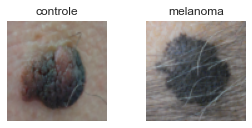

In [6]:
# Plots an example of each class
labels = np.unique(data['label'])

fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(4, 4)
fig.tight_layout()

for ax, label in zip(axes, labels):
    idx = data['label'].index(label)

    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

Segue-se com a estratificação dos dados, onde a base foi inicialmente particionada em 90% os dados sendo separados para treino dos modelos e 10% para teste. Optou-se por uma maior quantidade dedicada ao treino devido à pouca disponibilidade de amostras. O gráfico de barras exibe o balanceamento de amostras para cada conjunto resultante da estratificação.

In [7]:
X = np.array(data['data'])
y = np.array(data['label'])

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=2154
)

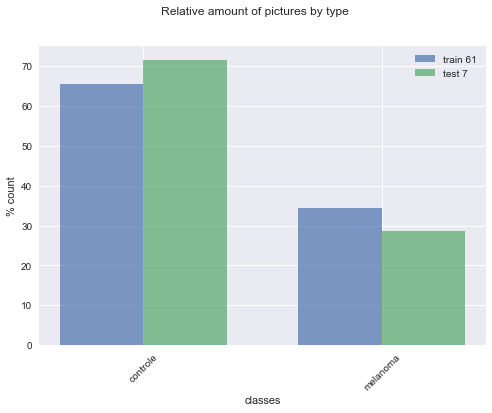

In [8]:
def plot_bar(y, loc='left', relative=True):
    """
    Plots a bar figure of the stratified samples.
    """
    width = 0.35
    if loc == 'left':
        n = -0.5
    else:
        n = 0.5

    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]

    if relative:  # plot as percentage
        counts = 100 * counts[sorted_index] / len(y)
        ylabel_text = '% count'
    else:  # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'

    xtemp = np.arange(len(unique))

    plt.bar(xtemp + n * width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('classes')
    plt.ylabel(ylabel_text)

plt.suptitle('Relative amount of pictures by type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend(([
    f'train {len(y_train)}',
    f'test {len(y_test)}'
]))

## Processamento

O exemplo demonstrado a seguir aplica a extração de características sob uma amostra qualquer. A técnica utilizada foi a HOG (*Histogram of Oriented Gradients*) apesentada inicialmente por Dalal *et al* (2005):

> A ideia básica é que a aparência e a forma do objeto local podem ser caracterizadas muito bem pela distribuição de gradientes de intensidade local ou direções de borda, mesmo sem o conhecimento preciso do gradiente ou posições de borda correspondentes. Na prática, isso é implementado dividindo a janela da imagem em pequenas regiões espaciais (“células”), para cada célula acumulando um histograma 1-D local de direções de gradiente ou orientações de borda sobre os pixels da célula. As entradas combinadas do histograma formam a representação. (DALAL et al., 2005)


Outra definição da técnica é apresentada por Kubayashi *et al* (2008):

> Um vetor de características HOG representa a forma local de um objeto, tendo informações de borda em várias células. Em regiões mais planas como um solo ou uma parede de um edifício, o histograma dos gradientes orientados tem uma distribuição mais plana. Por outro lado, na borda entre um objeto e o fundo, um dos elementos do histograma tem um valor grande e indica a direção da borda. Embora as imagens sejam normalizadas para posição e escala, as posições de recursos importantes não serão registradas com as mesmas posições da grade. Sabe-se que as características do HOG são robustas às transformações geométricas e fotométricas locais. Se as translações ou rotações do objeto forem muito menores que o tamanho do compartimento espacial local, seu efeito será pequeno. (KOBAYASHI et al., 2008)

A biblioteca do *skimage* implementa e disponibiliza uma função `hog` pronta para uso. Para aplicação prática deste trabalho será feito uso deste recurso pronto disponibilizado pela biblioteca acima mencionada.

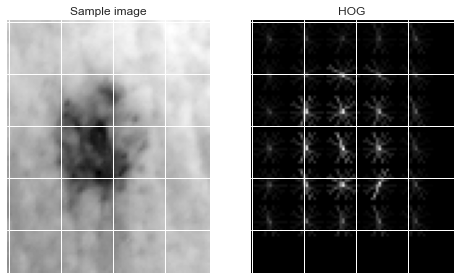

In [9]:
sample = imread(PATH+'/Positivos/0025_1.jpg', as_gray=True)
sample = rescale(sample, 1/3, mode='reflect')
sample_hog, sample_hog_img = hog(
    sample,
    pixels_per_cell=(14, 14),
    cells_per_block=(2, 2),
    orientations=9,
    visualize=True,
    block_norm='L2-Hys'
)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8, 6)

[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) for a in ax]

ax[0].imshow(sample, cmap='gray')
ax[0].set_title('Sample image')
ax[1].imshow(sample_hog_img, cmap='gray')
ax[1].set_title('HOG')
plt.show()

In [10]:
print('Number of pixels: ', sample.shape[0] * sample.shape[1])
print('Number of hog features: ', sample_hog.shape[0])

Number of pixels:  7566
Number of hog features:  720


In [11]:
# Convert color channels to grayscale, calculate HOGs and scale the data
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert RGB images to grayscale.
    """
    def __init__(self):
        ...

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.array([skimage.color.rgb2gray(img) for img in X])

    
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Calculate HOG features for each picture.
    """
    def __init__(self, y=None, orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm

    def fit(self, X, y=None):
        return self

    def local_hog(self, X):
        return hog(
            X,
            orientations=self.orientations,
            pixels_per_cell=self.pixels_per_cell,
            cells_per_block=self.cells_per_block,
            block_norm=self.block_norm
        )

    def transform(self, X, y=None):
        try:
            return np.array([self.local_hog(img) for img in X])
        except:
            return np.array([self.local_hog(img) for img in X])


Para que seja possível alimentar os modelos de aprendizado com os dados, é preciso transformar os dados, removendo os canais de cor e padronizando em escala de cinza, em seguida extrai-se as características aplica-se o escalonamento sobre os dados, desta forma tem-se os dados processados e prontos para ntrar nos modelos.

In [12]:
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()

# Process train data
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)

# Process test data
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

print(X_train_prepared.shape)
print(X_test_prepared.shape)

(61, 576)
(7, 576)


## Treinando um modelo

Para verificar o processamento aplicado sobre os dados, instancia-se um modelo SGD inicial para treinamento.

In [13]:
sgd_clf = SGDClassifier(random_state=2154, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=2154)

O modelo inicial apresenta uma pontuação de 85% de acertos. Porém como a amostra de teste é relativamente pequena este valor obtido pode ser facilmente ilusório.

In [14]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test))
print('\nPercentage correct: ', 100 * np.sum(y_pred == y_test)/len(y_test))

[ True  True  True  True  True False  True]

Percentage correct:  85.71428571428571


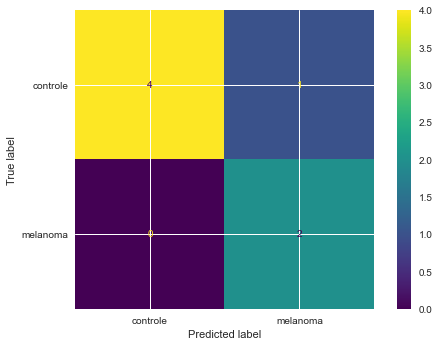

In [15]:
def get_scores(confusion_matrix, y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix.ravel()
    
    accuracy = (tp+tn) / (tp+tn+fp+fn)
    precision = tp / (tp+fp)
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    f1 = tp / (tp + ((fp+fn)*(1/2)))

    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'f1': f1,
        'precision': precision
    }


cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(sgd_clf, X_test_prepared, y_test)

In [16]:
scores = get_scores(cm, y_test, y_pred)
pd.DataFrame(
    [scores.values()],
    columns=scores.keys()
)

,accuracy,sensitivity,specificity,f1,precision
0,0.857143,1.0,0.8,0.8,0.666667


### Otimização do fluxo

Os modelos a serem testados são:

- Perceptron Multicamada
- Floresta Aleatória
- SGD
- Máquina de Vetor de Suporte

A rede neural (perceptron multicamada) por conter um espaço de parâmetros mais amplo passará por um pré-treinamento através de um *Grid Search* para encontrar uma opção de hiperparâmetros apropriada. Então treina-se executa-se um pipeline de processamento da entrada com busca de parâmetros e treino os modelos sob validação cruzada. Após o pipeline o melhor modelo será escolhido pelo Grid Search, a Figura 3 ilustra o pipeline utilizado no processamento:


<img src="https://i.ibb.co/jbmy6qN/pipeline.png" align="center" width="650" alt="Workflow">
<center>
    <small>
        <i>Figura 3: Pipeline de processamento. Fonte: O Autor.</i>
    </small>
</center>



In [17]:
HOG_pipeline = Pipeline([
    ('apply_grayscale', RGB2GrayTransformer()),
    ('apply_hog', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('rescale', StandardScaler()),
    ('classifier', SGDClassifier(random_state=2154, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct:  85.71428571428571


In [18]:
# MLP pre-training
mlp = MLPClassifier(random_state=2154)
parameter_space = {
    'hidden_layer_sizes': [(5, 5, 10), (50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [3000]
}
mlp = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=10)
mlp.fit(X_train_prepared, y_train)

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=2154), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu', 'logistic'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(5, 5, 10), (50, 50, 50),
                                                (50, 100, 50), (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [3000], 'solver': ['sgd', 'adam']})

In [19]:
param_grid = [
    {
        'apply_hog__orientations': [6, 8, 9, 12],
        'apply_hog__cells_per_block': [(2, 2), (3, 3), [4, 4]],
        'apply_hog__pixels_per_cell': [(8, 8), (10, 10), (12, 12), (14, 14), (16, 16)],
        'classifier': [
             SGDClassifier(random_state=2154, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear'),
             mlp.best_estimator_,
             RandomForestClassifier(n_estimators=100, max_depth=5),
         ]
    }
]

In [20]:
grid_search = GridSearchCV(
    HOG_pipeline,
    param_grid,
    cv=5,
    n_jobs=2,
    scoring='accuracy',
    verbose=1,
    return_train_score=True
)

search_result = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


In [21]:
search_result.best_estimator_

Pipeline(steps=[('apply_grayscale', RGB2GrayTransformer()),
                ('apply_hog',
                 HogTransformer(cells_per_block=[4, 4], orientations=12,
                                pixels_per_cell=(16, 16))),
                ('rescale', StandardScaler()),
                ('classifier', RandomForestClassifier(max_depth=5))])

## Avaliando o modelo

O score geral do modelo obtido:

In [22]:
print(f'Model score (%): {(search_result.best_score_ * 100):.2f}%')

Model score (%): 75.38%


In [23]:
best_pred = search_result.predict(X_test)
print(f'Percentage correct: {100*np.sum(best_pred == y_test)/len(y_test):.2f}%')

Percentage correct: 85.71%


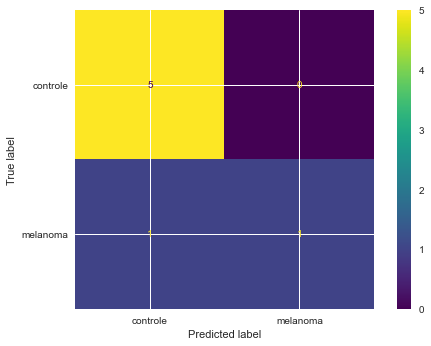

In [24]:
best_cm = confusion_matrix(y_test, best_pred)
plot_confusion_matrix(search_result, X_test, y_test)

In [25]:
best_scores = get_scores(best_cm, X_test, y_test)
pd.DataFrame(
    [best_scores.values()],
    columns=best_scores.keys()
)

,accuracy,sensitivity,specificity,f1,precision
0,0.857143,0.5,1.0,0.666667,1.0


# Análise CAP

Define-se uma baseline para ter uma ideia inicial de comparação do modelo. A baseline como sugere Vallantin (2018), é escolher a classe de maior ocorrências na amostra como resposta para todas as predições, entãou escolheu-se **controle** para todas as respostas do teste, obtendo uma acurácia de 71.42%.

In [26]:
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)

baseline_test = baseline.predict(X_test)
baseline_test_cm = confusion_matrix(y_test, baseline_test)
print('Confusion Matrix : \n', baseline_test_cm)
print(get_scores(baseline_test_cm, y_test, baseline_test))


Confusion Matrix : 
 [[5 0]
 [2 0]]
{'accuracy': 0.7142857142857143, 'sensitivity': 0.0, 'specificity': 1.0, 'f1': 0.0, 'precision': nan}


<ipython-input-15-cad805ad8ad5>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp+fp)


O modelo em si, para o teste obteve 85.71%

In [27]:
model_test_cm = confusion_matrix(y_test, best_pred)
print('Confusion Matrix : \n', model_test_cm)
print(get_scores(model_test_cm, y_test, best_pred))


Confusion Matrix : 
 [[5 0]
 [1 1]]
{'accuracy': 0.8571428571428571, 'sensitivity': 0.5, 'specificity': 1.0, 'f1': 0.6666666666666666, 'precision': 1.0}


Visualizando o modelo final contra a amostra de testes, pode-se dizer que é um modelo **Excelente** com uma acurácia de 85% e alta precisão.

In [28]:
def get_prediction_timeline(model, X, y):
    prediction_timeline = []
    count = 0
    for x_, y_ in zip(X, y):
        ty = model.predict([x_])[0]
        if (ty == y_):
            count += 1
            prediction_timeline.append(count)
        else:
            prediction_timeline.append(count)

    return prediction_timeline

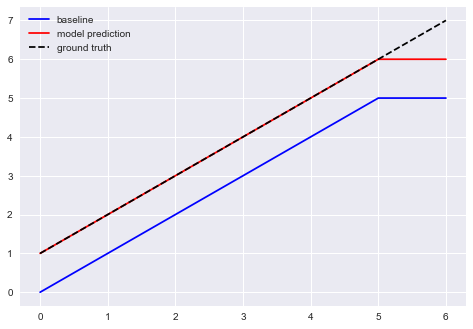

In [29]:
bsl_tl = get_prediction_timeline(baseline, X_test, y_test)
model_tl = get_prediction_timeline(search_result, X_test, y_test)

fig, ax = plt.subplots()

plt.plot(bsl_tl, label='baseline', color='blue')
plt.plot(model_tl, label='model prediction', color='red')
plt.plot([i+1 for i, _ in enumerate(y_test)], label='ground truth', color='black', linestyle='dashed')
plt.legend()

Porém avaliar o modelo unicamente sobre o conjunto de teste não é suficiente para provar sua eficiência, testando sobre o conjunto total de dados obtem-se uma baseline de 66.17% de acurácia.

In [44]:
baseline_y = baseline.predict(X)
baseline_cm = confusion_matrix(y, baseline_y)
print('Confusion Matrix : \n', baseline_cm)
print(get_scores(baseline_cm, y, baseline_y))


Confusion Matrix : 
 [[45  0]
 [23  0]]
{'accuracy': 0.6617647058823529, 'sensitivity': 0.0, 'specificity': 1.0, 'f1': 0.0, 'precision': nan}


<ipython-input-15-cad805ad8ad5>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp+fp)


Já o modelo treinado apresenta 98% de acurácia sobre os dados totais, podendo ser considerado como **sobreajustado** com sua margem muito próxima da resposta real, indicando que o modelo se adequu demasiadamente ao conjunto de dados em questão, reduzindo sua capacidade de generalização.

In [46]:
model_y = search_result.predict(X)
model_cm = confusion_matrix(y, model_y)
print('Confusion Matrix : \n', model_cm)
print(get_scores(model_cm, y, model_y))

Confusion Matrix : 
 [[45  0]
 [ 1 22]]
{'accuracy': 0.9852941176470589, 'sensitivity': 0.9565217391304348, 'specificity': 1.0, 'f1': 0.9777777777777777, 'precision': 1.0}


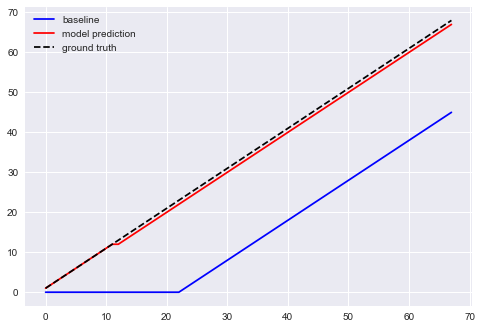

In [32]:
bsl_tl = get_prediction_timeline(baseline, X, y)
model_tl = get_prediction_timeline(search_result, X, y)

fig, ax = plt.subplots()

plt.plot(bsl_tl, label='baseline', color='blue')
plt.plot(model_tl, label='model prediction', color='red')
plt.plot([i+1 for i, _ in enumerate(y)], label='ground truth', color='black', linestyle='dashed')
plt.legend()

## Otimização dos modelos

Para avaliar outras possibilidades sobre o mesmo conjunto, estratifica-se o conjunto em outras frações para treinamento e avaliação dos modelos, nesse caso foram separadas 6 possibilidades de estratificação:

- 10% para teste e 90% para treino;
- 15% para teste e 85% para treino;
- 20% para teste e 80% para treino;
- 25% para teste e 75% para treino;
- 30% para teste e 70% para treino;
- 40% para teste e 60% para treino;

Assim será executado o pipeline de treino dos modelos em cada um os conjuntos obtidos para avaliar a escolha do modelo que esteja dentro dos padrões **bom** e **excelente** como proposto por Vallantin (2018).

In [33]:
train_test_sets = []
split_sizes = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4]

for size in split_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=size,
        shuffle=True,
        random_state=2154
    )
    train_test_sets.append((X_train, X_test, y_train, y_test))

# check test sample sizes
[len(i[1]) for i in train_test_sets]

[7, 11, 14, 17, 21, 28]

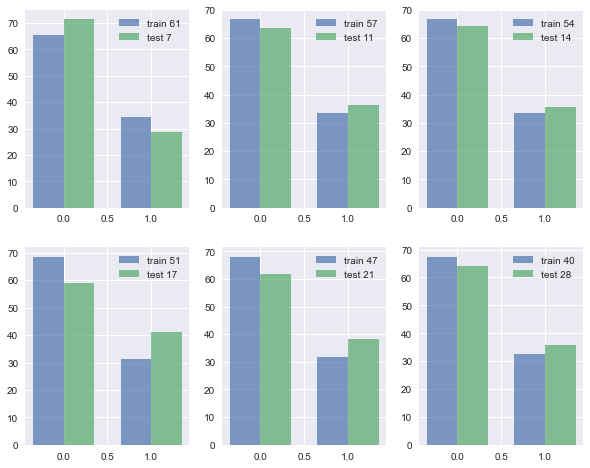

In [34]:
def multibar_plot(y, loc='left', relative=True, ax=None, label_legend=None):
    width = 0.35
    if loc == 'left':
        n = -0.5
    else:
        n = 0.5

    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]

    if relative:  # plot as percentage
        counts = 100 * counts[sorted_index] / len(y)
        ylabel_text = '% count'
    else:  # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'

    xtemp = np.arange(len(unique))
    
    ax.bar(xtemp + n * width, counts, align='center', alpha=.7, width=width, label=label_legend)
    ax.legend(loc='upper right')


fig, axs = plt.subplots(2, 3)
fig.set_size_inches(10, 8)

target_axs = [
    [0, 0], [0, 1], [0, 2],
    [1, 0], [1, 1], [1, 2]
]

for i, canvas in enumerate(target_axs):
    _, _, y_train, y_test = train_test_sets[i]
    multibar_plot(y_train, loc='left', ax=axs[canvas[0], canvas[1]], label_legend=f'train {len(y_train)}')
    multibar_plot(y_test, loc='right', ax=axs[canvas[0], canvas[1]], label_legend=f'test {len(y_test)}')

In [35]:
%%capture
# train models over each train set and store the results in a dict
results = {}
for train_test_set in train_test_sets:
    X_train, X_test, y_train, y_test = train_test_set
    pipe = HOG_pipeline.fit(X_train, y_train)  # adjuts the grid to the new train set
    grid_search = GridSearchCV(
        HOG_pipeline,
        param_grid,
        cv=5,
        n_jobs=2,
        scoring='accuracy',
        verbose=1,
        return_train_score=True
    )
    # grid search params to get the best model
    model = grid_search.fit(X_train, y_train)

    # test predictions
    pred = model.predict(X_test)
    cm = confusion_matrix(y_test, pred)

    # test baseline
    baseline_test = ['controle' for _ in y_test]
    baseline_test_cm = confusion_matrix(y_test, baseline_test)
    total = sum(sum(baseline_test_cm))
    baseline_test_accuracy = (baseline_test_cm[0, 0] + baseline_test_cm[1, 1]) / total
    
    # test scores
    test_scores = get_scores(cm, y_test, pred)

    # full dataset predictions
    fullset_pred = model.predict(X)
    fullset_cm = confusion_matrix(y, fullset_pred)
    fullset_accuracy = (fullset_cm[0, 0] + fullset_cm[1, 1]) / sum(sum(fullset_cm))

    # set scores
    set_scores = get_scores(fullset_cm, X, y)

    # full dataset baseline
    baseline = ['controle' for _ in y]
    baseline_cm = confusion_matrix(y, baseline)
    total = sum(sum(baseline_cm))
    baseline_accuracy = (baseline_cm[0, 0] + baseline_cm[1, 1]) / total

    # results structure
    results[f'{len(X_train)}x{len(X_test)}'] = {
        'model': model.best_estimator_,
        'score': model.best_score_ * 100,
        'correct_percentage': 100 * np.sum(pred == y_test) / len(y_test),
        'test_scores': test_scores,
        'set_scores': set_scores,
        'confusion_matrix': cm,
        'test_baseline_confusion_matrix': baseline_test_cm,
        'set_baseline_confusion_matrix': baseline_cm,
        'set_confusion_matrix': fullset_cm,
        'test_baseline_accuracy': baseline_test_accuracy,
        'set_baseline_accuracy': baseline_accuracy,
        'test_preds': pred,
        'set_preds': fullset_pred,
        'train_test_set': train_test_set
    }


In [36]:
test_table = []
set_table = []
general_table = []
columns = [
    'split_rate',
    'accuracy',
    'baseline_accuracy',
    'precision',
    'sensitivity',
    'specificity',
    'f1'
]
general_columns = ['split_rate', 'score', 'correct_percentage']


for k in results:
    test_table.append([
        k,
        results[k]['test_scores']['accuracy'],
        results[k]['test_baseline_accuracy'],
        results[k]['test_scores']['precision'],
        results[k]['test_scores']['sensitivity'],
        results[k]['test_scores']['specificity'],
        results[k]['test_scores']['f1'],
    ])
    set_table.append([
        k,
        results[k]['set_scores']['accuracy'],
        results[k]['set_baseline_accuracy'],
        results[k]['set_scores']['precision'],
        results[k]['set_scores']['sensitivity'],
        results[k]['set_scores']['specificity'],
        results[k]['set_scores']['f1'],
    ])
    general_table.append([k, results[k]['score'], results[k]['correct_percentage']])

test_results_df = pd.DataFrame(test_table, columns=columns)
set_results_df = pd.DataFrame(set_table, columns=columns)
general_results_df = pd.DataFrame(general_table, columns=general_columns)

In [37]:
test_results_df['acc_diff'] = test_results_df['accuracy'] - test_results_df['baseline_accuracy']
set_results_df['acc_diff'] = set_results_df['accuracy'] - set_results_df['baseline_accuracy']
general_results_df['test_gain'] = test_results_df['acc_diff']
general_results_df['set_gain'] = set_results_df['acc_diff']

In [38]:
test_results_df

,split_rate,accuracy,baseline_accuracy,precision,sensitivity,specificity,f1,acc_diff
0,61x7,0.857143,0.714286,1.000000,0.500000,1.000000,0.666667,0.142857
1,57x11,0.909091,0.636364,1.000000,0.750000,1.000000,0.857143,0.272727
2,54x14,0.857143,0.642857,1.000000,0.600000,1.000000,0.750000,0.214286
3,51x17,0.647059,0.588235,1.000000,0.142857,1.000000,0.250000,0.058824
4,47x21,0.666667,0.619048,0.666667,0.250000,0.923077,0.363636,0.047619
5,40x28,0.750000,0.642857,0.800000,0.400000,0.944444,0.533333,0.107143


In [39]:
set_results_df

,split_rate,accuracy,baseline_accuracy,precision,sensitivity,specificity,f1,acc_diff
0,61x7,0.985294,0.661765,1.000000,0.956522,1.000000,0.977778,0.323529
1,57x11,0.985294,0.661765,1.000000,0.956522,1.000000,0.977778,0.323529
2,54x14,0.970588,0.661765,1.000000,0.913043,1.000000,0.954545,0.308824
3,51x17,0.911765,0.661765,1.000000,0.739130,1.000000,0.850000,0.250000
4,47x21,0.897059,0.661765,0.944444,0.739130,0.977778,0.829268,0.235294
5,40x28,0.897059,0.661765,0.944444,0.739130,0.977778,0.829268,0.235294


In [40]:
general_results_df

,split_rate,score,correct_percentage,test_gain,set_gain
0,61x7,75.512821,85.714286,0.142857,0.323529
1,57x11,73.787879,90.909091,0.272727,0.323529
2,54x14,72.181818,85.714286,0.214286,0.308824
3,51x17,74.727273,64.705882,0.058824,0.250000
4,47x21,79.111111,66.666667,0.047619,0.235294
5,40x28,80.000000,75.000000,0.107143,0.235294


A análise CAP indicará quais modelos são aceitáveis, ressaltando que de acordo com Vallantin (2018) um modelo aceitável deve estar entre a *baseline* e a abstração da resposta perfeita.

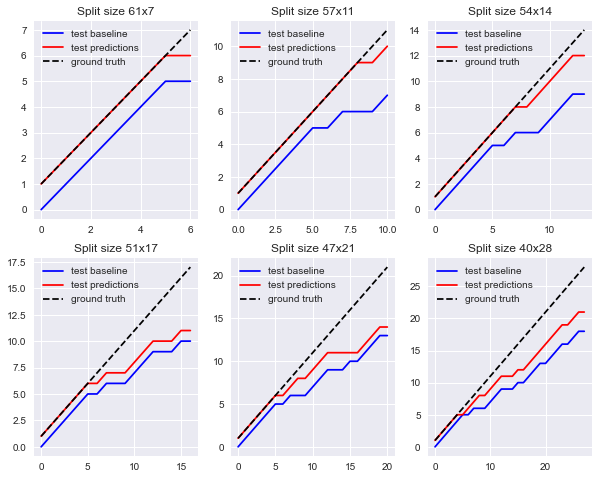

In [48]:
# test model cap comparisons
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(10, 8)

for ax, k in zip(target_axs, results):
    X_train, X_test, y_train, y_test = results[k]['train_test_set']
    baseline = DummyClassifier(strategy='most_frequent')
    baseline.fit(X_train, y_train)
    baseline_tl = get_prediction_timeline(baseline, X_test, y_test)
    model = results[k]['model']
    model_tl = get_prediction_timeline(model, X_test, y_test)
    
    axs[ax[0], ax[1]].plot(baseline_tl, label='test baseline', color='blue')
    axs[ax[0], ax[1]].plot(model_tl, label='test predictions', color='red')
    axs[ax[0], ax[1]].plot([(i+1) for i, _ in enumerate(y_test)], label='ground truth', color='black', linestyle='dashed')
    axs[ax[0], ax[1]].legend()
    axs[ax[0], ax[1]].set_title(f'Split size {k}')


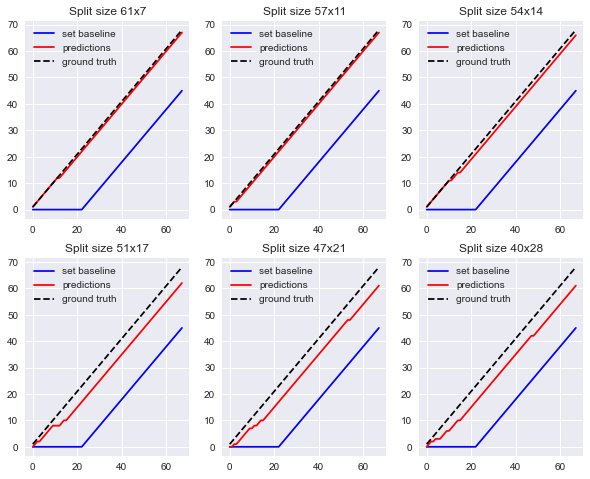

In [42]:
# Set cap models comparison
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(10, 8)

for ax, k in zip(target_axs, results):
    baseline = DummyClassifier(strategy='most_frequent')
    baseline.fit(X, y)
    baseline_tl = get_prediction_timeline(baseline, X, y)
    model = results[k]['model']
    model_tl = get_prediction_timeline(model, X, y)

    axs[ax[0], ax[1]].plot(baseline_tl, label='set baseline', color='blue')
    axs[ax[0], ax[1]].plot(model_tl, label='predictions', color='red')
    axs[ax[0], ax[1]].plot([i+1 for i, _ in enumerate(y)], label='ground truth', color='black', linestyle='dashed')
    axs[ax[0], ax[1]].legend()
    axs[ax[0], ax[1]].set_title(f'Split size {k}')


### Análise final

Os três primeiros modelos (61x7, 57x11, 54x14) apresentam alta propensão ao sobreajuste, estando muito próximos da borda superior, demonstrando alta capacidade de reagir sobre **este** conjunto de dados, os modelos (51x17, 47x21, 40x28) apresentam maior propensão à generalização. O modelo 57x11 deonstrou um ganho de acurácia de 27% em relação à sua baseline no teste, muito a frente dos demais modelos. Para fins de conclusão o modelo escolhido é o modelo `40x28` sendo caracterizado na aplicação como *default*, para fins de testes os demais modelos serão implatados para seleção opcional.

## Save models

In [54]:
# Save the model
model_version = 'v:1'
for k, v in results.items():
    file_name = f'{k}_{model_version}.model'
    joblib.dump(v, file_name)
    print('Saved model ', file_name)

Saved model  61x7_v:1.model
Saved model  57x11_v:1.model
Saved model  54x14_v:1.model
Saved model  51x17_v:1.model
Saved model  47x21_v:1.model
Saved model  40x28_v:1.model


## Deploy

~~(seção bônus)~~

Para simular e testar todo pipeline do desenvolvimento e simular a execução do modelo salvo em um ambiente de produção, desenvolveu-se [uma pequena aplicação]() que recebe uma imagem e classifica em **melanoma** ou **controle**. Uma *demo* da aplicação está disponível em: `https://hippocrates.brunolcarli.repl.co/`.



## Conclusão

A viabilidade de implementação de um classificador utilizando procedimentos manuais através das ferramentas disponibilizadas pelo scikit-learn foram possíveis de serem realizadas com facilidade. Mesmo com uma base de dados pequena, a taxa de acerto de 89%  precisão média de 94% é razoávelmente boa, porém este valor pode facilmente ser melhorado ao incluir mais imagens de amostra apresentando boa capacidade de predição e otimização. Para esta amostra a estrategia de se dividir o conjunto de dados m diferentes porções também foi um ponto fundamental para análise. diferentes possibiidades de resultados. A aplicação do HOG também se demonstrou uma técnica promissiora para a classificação de imagens de melanoma.

# Referências

<hr />

DALAL, Navneet et al. Histograms of Oriented Gradients for Human Detection. IEEE COMPUTER SOCIETY CONFERENCE ON COMPUTER VISION AND PATTERN RECOGNITION, 2005, San Diego, CA, USA. DOI 10.1109/CVPR.2005.177. Disponível em: http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf. Acesso em: 18 jan. 2022.

HARRISON, Matt. Machine Learning: Guia de Referência Rápida. 1. ed. São Paulo: Novatec, 2020. 272 p. ISBN 9781492047544.

KOBAYASHI, Takuya et al. Selection of Histograms of Oriented Gradients Features for Pedestrian Detection. 14TH ICONIP 2007, Kitakyushu, Japan. Neural Information Processing, Springer, 2008. Tema: Real world applications, p. 598-607. DOI 10.1007/978-3-540-69162-4_62. Disponível em: https://dblp.org/rec/conf/iconip/KobayashiHK07. Acesso em: 17 jan. 2022.

VALLANTIN, Lima. Why you should not trust only in accuracy to measure machine learning performance. 6 set. 2018. Disponível em: https://medium.com/@limavallantin/why-you-should-not-trust-only-in-accuracy-to-measure-machine-learning-performance-a72cf00b4516. Acesso em: 13 jan. 2022.

VAN DER WALT, Stéfan. Scikit-image: image processing in Python, 2014. Disponível em: https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html. Acesso em: 18 jan. 2022.

<br/>